In [323]:
import math
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.datasets import make_regression
from sklearn.datasets import make_blobs

from sklearn.metrics import accuracy_score

warnings.filterwarnings("ignore")
%matplotlib inline


import logging
import yaml
from logging import config

import collections

In [321]:
class DecisionStump():
    
    def __init__(self, original_X, original_y, n_features = 1, n_thresholds = 40):
        self.original_X = original_X 
        self.original_y = original_y
        self.n_features = n_features
        self.n_thresholds = n_thresholds
        self.best_threshhold = None
        self.best_MSE = None
        self.l_mean = None
        self.r_mean = None

    def SE(self, a, b):
        return (a - b)**2

    def split_feature(self, x, y):
        '''
        Splits single feature, minimizing MSE
        '''
        xmin = np.min(x)
        xmax = np.max(x)
        thresholds = np.linspace(xmin, xmax, self.n_thresholds + 2)
        MSE = []
        for t in thresholds[1:-2]:
            L = y[np.squeeze(x <= t)]
            R = y[np.squeeze(x > t)]
            n_l = len(L)
            n_r = len(R)
            n = n_l + n_r
            mse = n_l / n * ((L - L.mean())**2).sum() + n_r / n * ((R - R.mean())**2).sum()
            MSE.append(mse)
        best_index = np.argmin(MSE)
        return MSE[best_index], thresholds[best_index + 1]


    def fit(self, X, y):
        self.best_MSE, self.best_threshhold = self.split_feature(X, y)
        self.l_mean = y[np.squeeze(X <= self.best_threshhold)].mean()
        self.r_mean = y[np.squeeze(X > self.best_threshhold)].mean()
        return self

    def predict(self, X, y = None):
        lam = lambda x: self.l_mean if x<=self.best_threshhold else self.r_mean
        y = np.array([lam(xi) for xi in X])
        return y

    def predictone(self, x, y = None):
        if x<=self.best_threshhold:
            return self.original_y[np.squeeze(self.original_X <= self.best_threshhold)].mean()
        else:
            return self.original_y[np.squeeze(self.original_X > self.best_threshhold)].mean()
            

In [322]:
class myXGB:
    
    def __init__(self, X, y, n_estimators = 8):
        self.n_estimators = n_estimators
        self.estimators = []
        self.ys = []
        for i in range(self.n_estimators):
            self.estimators.append(DecisionStump(X, y))
            
    
    def fit(self, X, y):
        for estimator in self.estimators:
            self.ys.append(y)
            estimator.fit(X, y)
            y_pred = estimator.predict(X, y)
            y = y - y_pred
        return self
    
    def predict(self, X):
        y = np.zeros(X.shape[0])
        for j, xi in enumerate(X):
            for i, estimator in enumerate(
                                sorted(self.estimators, 
                                key=lambda x: x.best_threshhold, 
                                reverse=False)):
                if xi <= estimator.best_threshhold and y[j]==0:
                    y[j] = estimator.predictone(xi)
                    break
                elif ((i+1 != len(self.estimators)) and (xi <= self.estimators[i+1].best_threshhold) and y[j]==0):
                    y[j] = estimator.predictone(xi)
                    break
                elif ((i+1 == len(self.estimators)) and (xi > estimator.best_threshhold) and y[j]==0):
                    y[j] = estimator.predictone(xi)
                    break
                else:
                    pass
        return y

In [316]:
X = np.linspace(0,10,300)[:, np.newaxis]
random = np.random.RandomState(42)
noise = np.concatenate((random.normal(scale=.2,size=(100,1)), random.normal(scale=.5,size=(200,1))))
y = np.concatenate((np.zeros((100,1))+2, np.sin(0.5*X[100:200])+3, X[200:300]-4.2, ) ) + noise
y = y.reshape(-1)

In [317]:
modelXGB = myXGB(X,y).fit(X,y)
y_pred_1 = modelXGB.predict(X)

In [318]:
for i in sorted(modelXGB.estimators, 
                                key=lambda x: x.best_threshhold, 
                                reverse=False):
    print(i.best_threshhold, i.best_MSE)

3.4146341463414633 114.79065251896583
5.609756097560975 48.5472652417407
6.341463414634147 46.39496133171093
6.585365853658536 46.47758359059551
6.585365853658536 46.282335684612995
6.585365853658536 46.282335684612995
6.585365853658536 46.282335684612995
7.804878048780488 66.68312369001123


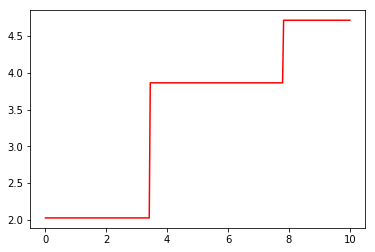

In [319]:
plt.plot(X, y_pred_1,
           c='r',
           label='1st tree ($T_1$) prediction');

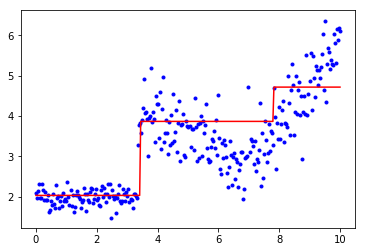

In [320]:
plt.scatter(X, y, color='blue', marker='.', label='Salary')
plt.plot(X, y_pred_1,
           c='r',
           label='1st tree ($T_1$) prediction');
plt.show()